# Compare MARIO to CytoVI on the Nunez dataset

In [21]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import cytovi
from mario.match import Mario 
from mario.match_utils import eval_matching_accuracy
from mario.match import pipelined_mario

In [22]:
os.chdir('/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/notebooks/')
figure_dir = '../figures/figure2/'

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["savefig.dpi"] = 300

sc.settings.figdir = figure_dir
sc.set_figure_params(dpi_save = 300)
# sc.settings.n_jobs = 40

In [ ]:
expr_df = pd.read_csv('/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-06-05_aurora_batch_figure_expression.csv', index_col=0)
obs = pd.read_csv('/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2024-06-05_aurora_batch_figure_obs.csv', index_col=0)

In [ ]:
expr_batch1 = expr_df.loc[(obs['batch'] == 0).values].copy()
expr_batch2 = expr_df.loc[(obs['batch'] == 1).values].copy()

In [ ]:
# run mario
df1 = expr_batch1
df2 = expr_batch2

save_path = '/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2025-08-14_MARIO_tests/'

# run mario
final_matching_lst, embedding_lst = pipelined_mario(data_lst=[df1, df2])

# match ind
df1_rowidx=list(range(len(final_matching_lst[1])))
filtered_out=[i for i,x in enumerate(final_matching_lst[1]) if not x]

match_final_df1 =[e for e in df1_rowidx if not e in filtered_out]
match_final_df2 = [item for sublist in final_matching_lst[1] for item in sublist]

df1_filtered = df1.iloc[match_final_df1,]
df2_filtered = df2.iloc[match_final_df2,]

df1_filtered.to_csv(save_path + '2025-08-14_df1_filtered.csv')
df2_filtered.to_csv(save_path + '2025-08-14_df2_filtered.csv')

emb1 = embedding_lst[0]
emb2 = embedding_lst[1]

np.save(save_path + '2025-08-14_embedding_batch1.npy', emb1)
np.save(save_path + '2025-08-14_embedding_batch2.npy', emb2)

removed_df1_idx = df1.index.difference(df1_filtered.index)
removed_df2_idx = df2.index.difference(df2_filtered.index)
removed_idx = removed_df1_idx.union(removed_df2_idx).values

np.save(save_path + '2025-08-14_removed_idx.npy', removed_idx)

In [23]:
# read the output of mario and construct the adata object
data_path = '/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2025-08-14_MARIO_tests/'

df1_filtered = pd.read_csv(data_path + '2025-08-14_df1_filtered.csv', index_col=0)
df2_filtered = pd.read_csv(data_path + '2025-08-14_df2_filtered.csv', index_col=0)


emd1 = np.load(data_path + '2025-08-14_embedding_batch1.npy')
emd2 = np.load(data_path + '2025-08-14_embedding_batch2.npy')

rm_ind = np.load(data_path + '2025-08-14_removed_idx.npy')


# duplicated ind
dup_ind = df2_filtered.index[df2_filtered.index.duplicated()].to_numpy()
rm_ind = np.concatenate((rm_ind, dup_ind))

# remove duplicate cells
df2_filtered_unique = df2_filtered.iloc[~df2_filtered.index.isin(rm_ind),]
emd2_unique = emd2[~df2_filtered.index.isin(rm_ind)]

adata1 = ad.AnnData(df1_filtered)
adata1.obs['batch'] = '0'
adata1.layers['scaled'] = adata1.X.copy()
adata1.obsm['X_mario'] = emd1

adata2 = ad.AnnData(df2_filtered_unique)
adata2.obs['batch'] = '1'
adata2.layers['scaled'] = adata2.X.copy()
adata2.obsm['X_mario'] = emd2_unique

adata_filt = ad.concat([adata1, adata2], index_unique=None)

/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
# note:
# 50000 of original data were not matched
# 50000 of original data were duplicates (due to multiple matching)
# in total 77846 cells were removed

In [24]:
# read anndata again
adata_comb = ad.read_h5ad('/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2025-08-15_aurora_batch_new_hyper_latents_umap_bm_comp.h5ad')
adata_comb

AnnData object with n_obs × n_vars = 200000 × 41
    obs: 'filename', 'sample_id', 'tube', 'Vial Number', 'batch', 'leiden_PCA', 'cell_type', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'neighbors', 'neighbors_CytoVI_minmax', 'neighbors_CytoVI_rank', 'neighbors_CytoVI_zscore', 'pca', 'umap'
    obsm: 'X_CytoVI_minmax', 'X_CytoVI_rank', 'X_CytoVI_zscore', 'X__umap_unintegrated', 'X_cycombine_minmax', 'X_cycombine_rank', 'X_cycombine_zscore', 'X_fastmnn_minmax', 'X_fastmnn_rank', 'X_fastmnn_zscore', 'X_harmony_minmax', 'X_harmony_rank', 'X_harmony_zscore', 'X_pca', 'X_umap', 'X_umap_CytoVI_minmax', 'X_umap_CytoVI_rank', 'X_umap_CytoVI_zscore', 'X_umap_cycombine_minmax', 'X_umap_cycombine_rank', 'X_umap_cycombine_zscore', 'X_umap_fastmnn_minmax', 'X_umap_fastmnn_rank', 'X_umap_fastmnn_zscore', 'X_umap_harmony_minmax', 'X_umap_harmony_rank', 'X_umap_harmony_zscore', 'X_umap_unintegrated_minmax', 'X_umap_unintegrated_rank', 

In [5]:
# copy obs and obsm
ind_to_keep = adata_filt.obs.index.to_numpy().astype(int)
adata_filt.obs = adata_comb.obs.iloc[ind_to_keep].copy()

adata_filt.obsm['X_unintegrated_minmax'] = adata_comb.layers['scaled'][ind_to_keep,:].copy()

## train CytoVI model on subset of MARIO mapped cells

In [6]:
train_kwargs = {
        "n_epochs_kl_warmup": 250
        }

model_kwargs = {
        'n_latent': 20
        }


cytovi.CytoVI.setup_anndata(
    adata_filt,
    layer="scaled",
    batch_key='batch'
)

model = cytovi.CytoVI(adata_filt, **model_kwargs)
model.train(**train_kwargs)

adata_filt.obsm["X_CytoVI_minmax"] = model.get_latent_representation()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 30 records. Best score: -69.159. Signaling Trainer to stop.


In [7]:
sc.pp.neighbors(adata_filt, use_rep='X_CytoVI_minmax')
sc.tl.umap(adata_filt)
adata_filt.obsm["X_umap_CytoVI_minmax"] = adata_filt.obsm['X_umap'].copy()

In [8]:
sc.pp.neighbors(adata_filt, use_rep='X_mario')
sc.tl.umap(adata_filt)
adata_filt.obsm["X_umap_mario"] = adata_filt.obsm['X_umap'].copy()

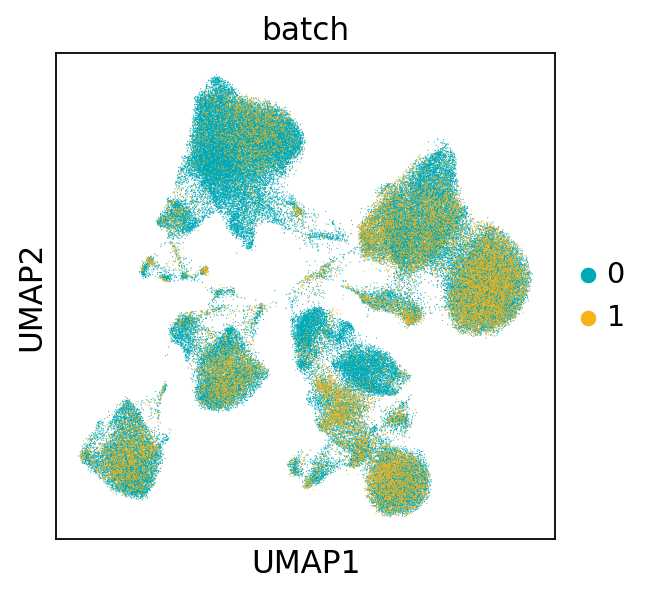

In [9]:
sc.pl.umap(adata_filt, color = 'batch', palette=adata_comb.uns['batch_colors'].tolist())

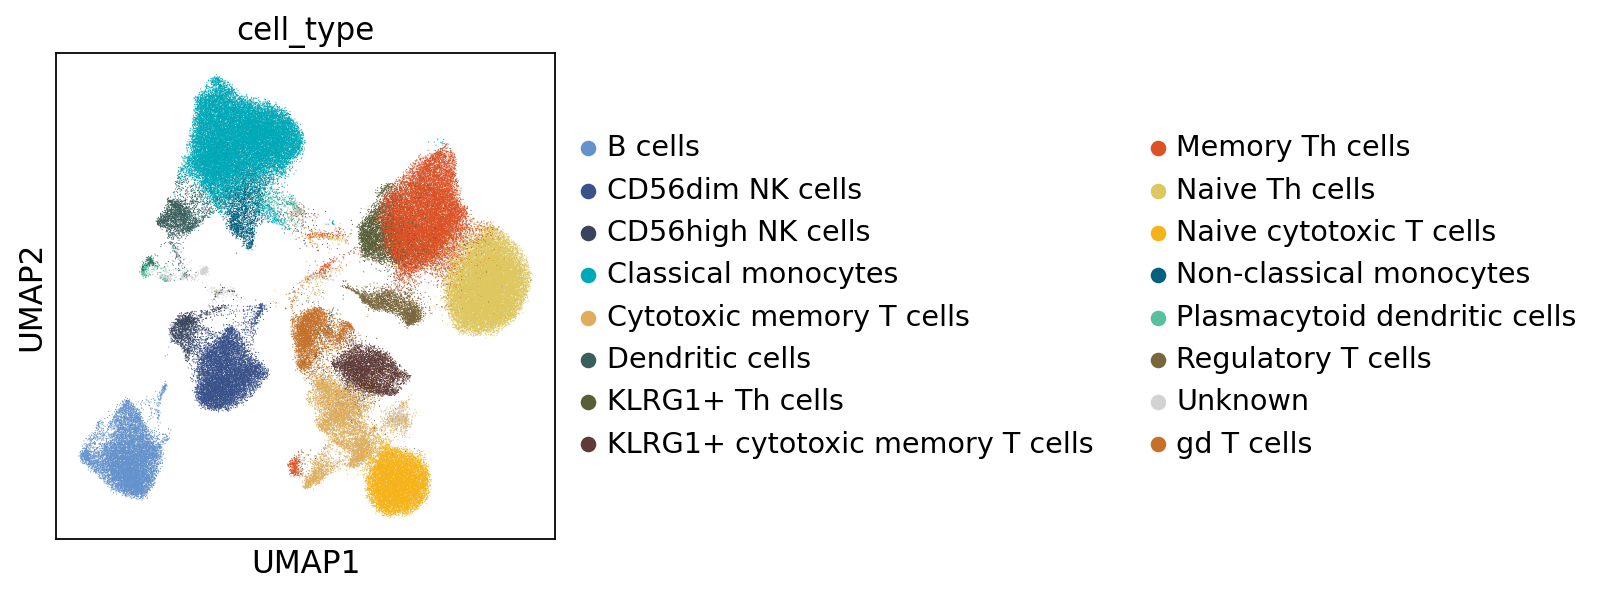

In [10]:
sc.pl.umap(adata_filt, color = 'cell_type', palette=adata_comb.uns['cell_type_colors'].tolist())

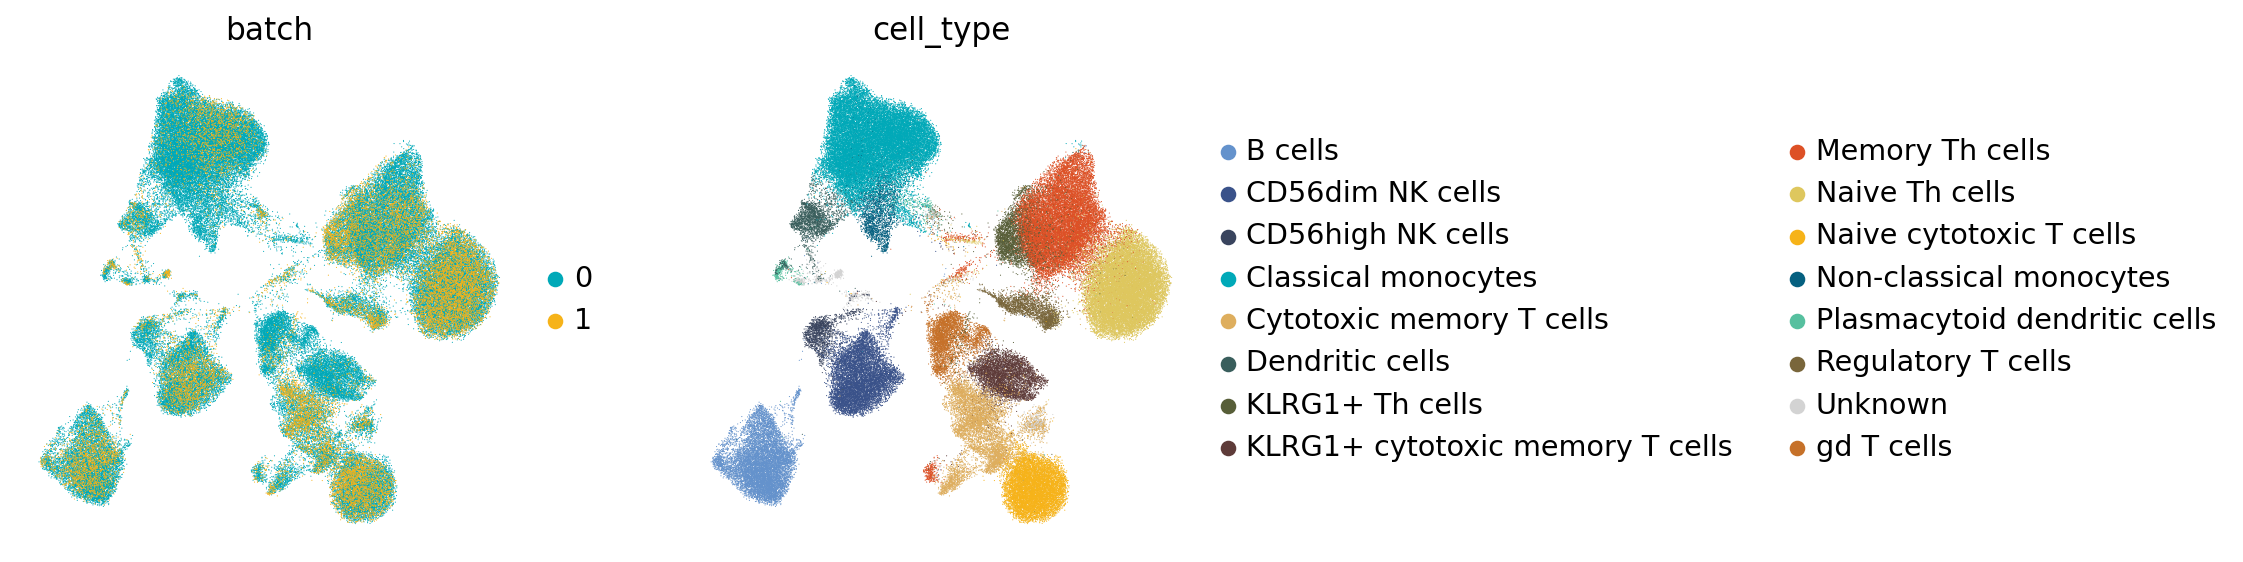

In [11]:
sc.pl.umap(adata_filt, color = ['batch', 'cell_type'], frameon= False, save = 'embedding_multi_batch_mario.png')

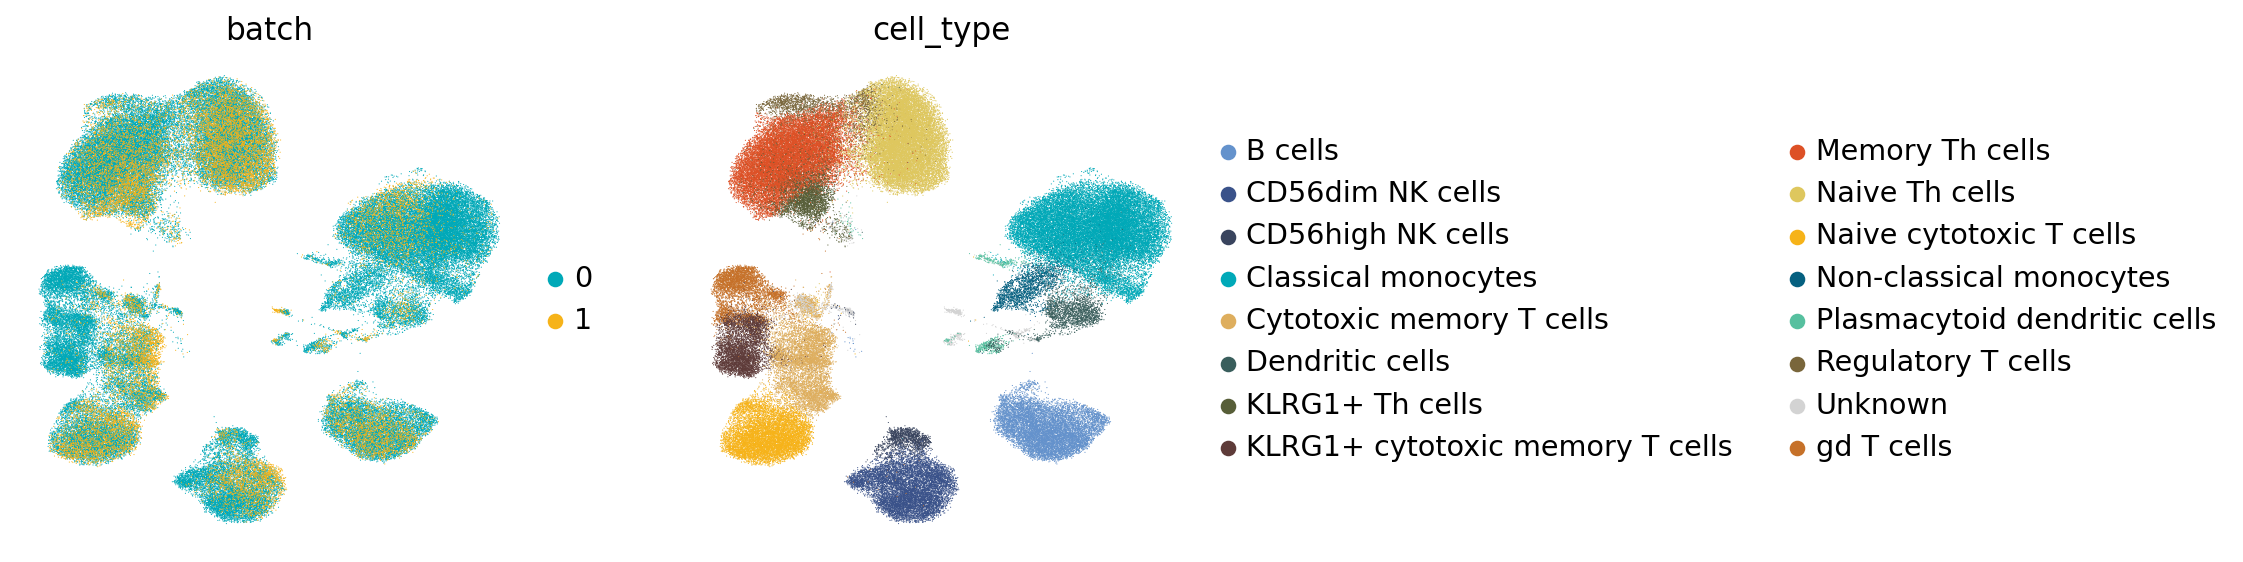

In [12]:
sc.pl.embedding(adata_filt, basis='X_umap_CytoVI_minmax', color = ['batch', 'cell_type'], frameon= False, save = 'embedding_multi_batch_cytovi.png')

In [20]:
adata_filt.write('/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2025-08-28_aurora_batch_new_hyper_latents_umap_bm_comp_with_CytoVI_sub.h5ad')

## Run scib of CytoVI vs Mario

In [13]:
# perform scib
adata_bm = adata_filt[adata_filt.obs['cell_type'] != 'Unknown', :].copy()
adata_bm.obs['cell_type'].cat.remove_unused_categories()

adata_bm = cytovi.pp.subsample(adata_bm, n_obs = 20000, groupby = 'batch').copy()

latent_obsm_keys = ['X_unintegrated_minmax', 'X_CytoVI_minmax', 'X_mario']

adata_bm.X = adata_bm.layers['scaled'].copy()

/home/projects/amit/floriani/github_repos/CytoVI_dev/src/cytovi/pp/cyto_pp.py:355: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  index = adata.obs.groupby(groupby, as_index=False).apply(


In [15]:
# perform the actual benchmarking
from scib_metrics.benchmark import Benchmarker, BioConservation

biocon = BioConservation(nmi_ari_cluster_labels_leiden = True, nmi_ari_cluster_labels_kmeans = False)

bm = Benchmarker(
    adata_bm,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=latent_obsm_keys,
    pre_integrated_embedding_obsm_key='X_unintegrated_minmax',
    bio_conservation_metrics = biocon,
    # n_jobs=40,
)
bm.benchmark()

Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]WARNING:jax._src.xla_bridge:An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  33%|███▎      | 1/3 [02:09<04:19, 129.97s/it]/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in 

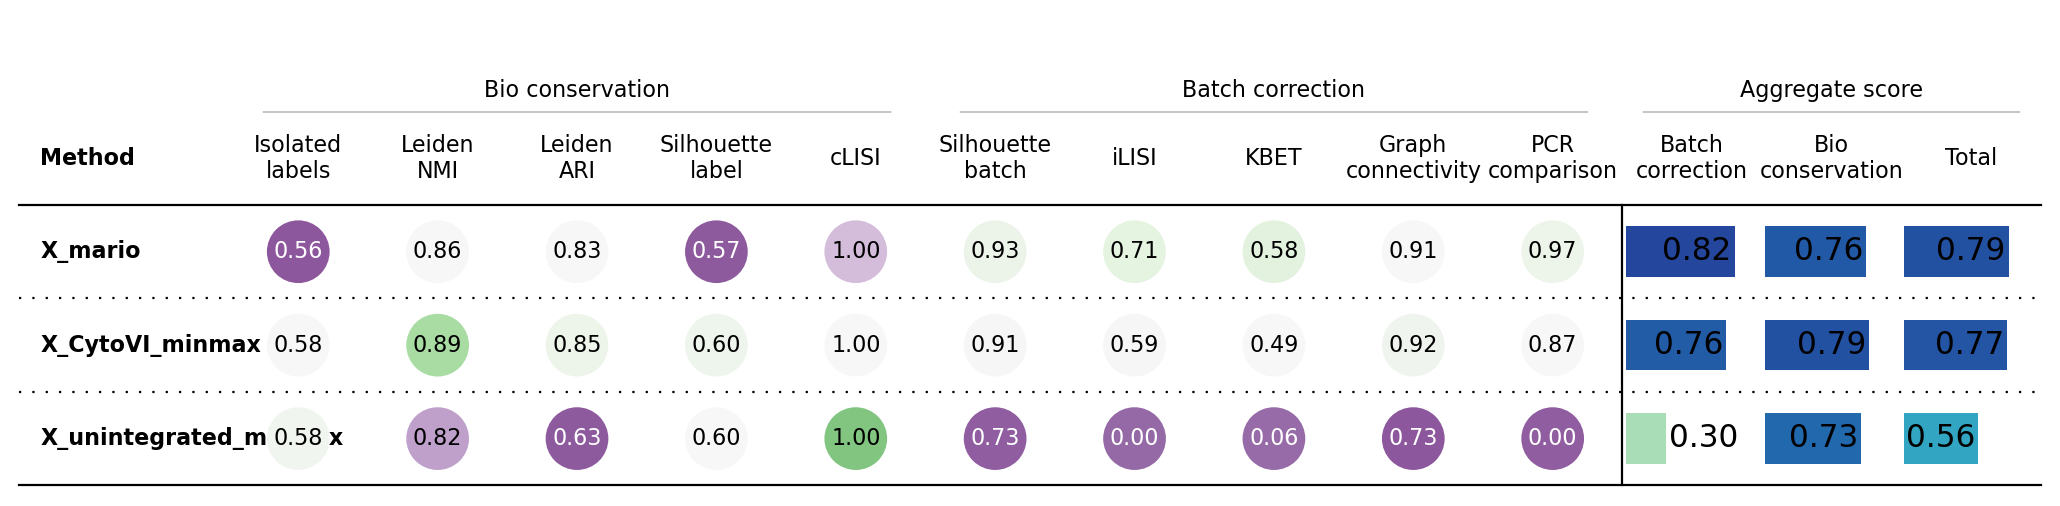

In [16]:
bm.plot_results_table(min_max_scale = False, show = False)

In [17]:
# save bm results as csv
bm.get_results(min_max_scale=False).to_csv('/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2028-08-15_aurora_batch_figure_scib_results_mario_minmax.csv')

In [18]:
# read again and do costumn plotting
bm_res = pd.read_csv('/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/2024-01-16_model_eval_multi_batch/2028-08-15_aurora_batch_figure_scib_results_mario_minmax.csv', index_col = 0)
bm_res.rename(index = {'X_mario': 'X_mario_minmax'}, inplace=True)

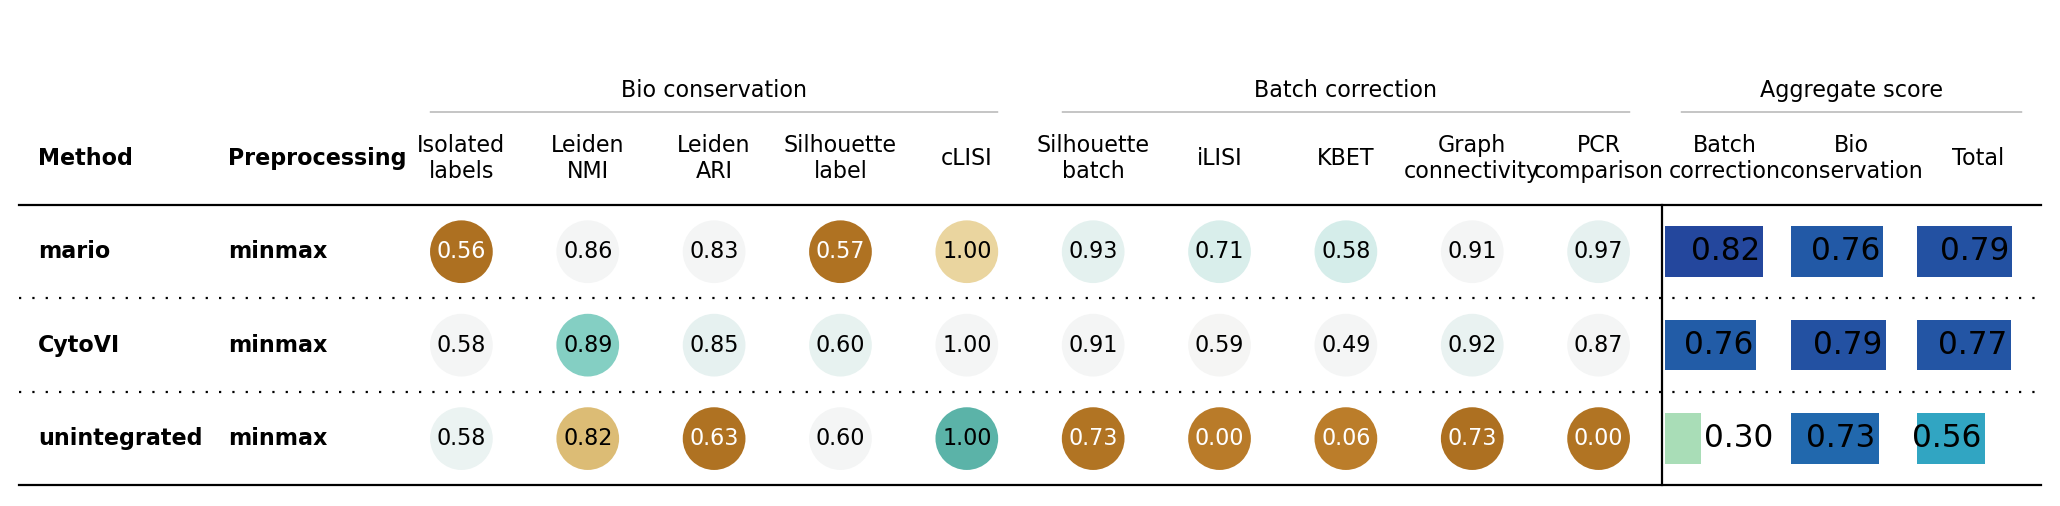

In [19]:
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
import matplotlib.pyplot as plt
import numpy as np

cmap_fn = lambda col_data: normed_cmap(col_data, cmap=plt.cm.BrBG, num_stds=2.5)

# Drop 'Metric Type' from the DataFrame
plot_df = bm_res.drop('Metric Type', axis=0)
num_embeds = plot_df.shape[0]

# Sort by total score
plot_df = plot_df.sort_values(by="Total", ascending=False).astype(np.float64)
plot_df["Method"] = plot_df.index

# Split the Method column into two columns, filling missing parts with empty strings
split_methods = plot_df['Method'].str.split('_', n=2, expand=True)
plot_df['Method'] = split_methods[1]
plot_df['Preprocessing'] = split_methods[2]
# plot_df['Method_Part2'] = split_methods[1].fillna('')

# Rearrange the columns to put the new Method_Part1 and Method_Part2 columns at the beginning
cols = ['Method', 'Preprocessing'] + [col for col in plot_df.columns if col not in ['Method', 'Preprocessing']]
plot_df = plot_df[cols]

# plot_df = plot_df.drop(columns=['Method'])

# Split columns by metric type
score_cols = bm_res.columns[bm_res.loc['Metric Type'] == 'Aggregate score']
other_cols = bm_res.columns[bm_res.loc['Metric Type'] != 'Aggregate score']
other_cols = [col for col in other_cols if col != 'New_col']

column_definitions = [
    ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"}),
    ColumnDefinition("Preprocessing", width=1.5, textprops={"ha": "left", "weight": "bold"}),
]

# Circles for the metric values
column_definitions += [
    ColumnDefinition(
        col,
        title=col.replace(" ", "\n", 1),
        width=1,
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "circle", "pad": 0.25},
        },
        cmap=cmap_fn(plot_df[col]),
        group=bm_res.loc['Metric Type', col],
        formatter="{:.2f}",
    )
    for i, col in enumerate(other_cols)
]

# Bars for the aggregate scores
column_definitions += [
    ColumnDefinition(
        col,
        width=1,
        title=col.replace(" ", "\n", 1),
        plot_fn=bar,
        plot_kw={
            "cmap": plt.cm.YlGnBu,
            "plot_bg_bar": False,
            "annotate": True,
            "height": 0.9,
            "formatter": "{:.2f}",
        },
        group=bm_res.loc['Metric Type', col],
        border="left" if i == 0 else None,
    )
    for i, col in enumerate(score_cols)
]

# Allow to manipulate text post-hoc (in illustrator)
size = 1

with plt.rc_context({"svg.fonttype": "none"}):
    fig, ax = plt.subplots(figsize=(len(bm_res.columns) * 1.25 * size, 3 + 0.3 * num_embeds * size))
    tab = Table(
        plot_df,
        cell_kw={
            "linewidth": 0,
            "edgecolor": "k",
        },
        column_definitions=column_definitions,
        ax=ax,
        row_dividers=True,
        footer_divider=True,
        textprops={"fontsize": 10, "ha": "center"},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
        column_border_kw={"linewidth": 1, "linestyle": "-"},
        index_col='Method', 
    ).autoset_fontcolors(colnames=plot_df.columns)

plt.show()
fig.savefig(os.path.join(figure_dir, "scib_results_mario.pdf"), facecolor=ax.get_facecolor(), dpi=300)

## Explore cells not integrated by MARIO on CytoVI latent space

In [141]:
comb_ind_nm = adata_comb.obs.iloc[rm_ind].index
adata_comb.obs['mario_mapped'] = 'mapped'
adata_comb.obs.loc[comb_ind_nm, 'mario_mapped'] = 'removed'

In [157]:
# compute relative frequency of cell types that were mapped vs removed
adata_comb_batch1 = adata_comb[adata_comb.obs['batch']=='1'].copy()

cell_type_freq = adata_comb_batch1.obs.groupby(['cell_type', 'mario_mapped']).size().unstack(fill_value=0)
cell_type_rel_freq = cell_type_freq.div(cell_type_freq.sum(axis=0), axis=1)*100

/tmp/ipykernel_31241/304158456.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_freq = adata_comb_batch1.obs.groupby(['cell_type', 'mario_mapped']).size().unstack(fill_value=0)


In [158]:
cell_type_rel_freq

mario_mapped,mapped,removed
cell_type,,
B cells,9.277387,6.751283
CD56dim NK cells,8.418617,6.982174
CD56high NK cells,0.680787,0.652684
Classical monocytes,8.854677,12.146893
Cytotoxic memory T cells,10.358637,9.872817
Dendritic cells,1.673044,1.538839
KLRG1+ Th cells,6.033639,7.045378
KLRG1+ cytotoxic memory T cells,0.520602,1.473054
Memory Th cells,13.433301,11.216882


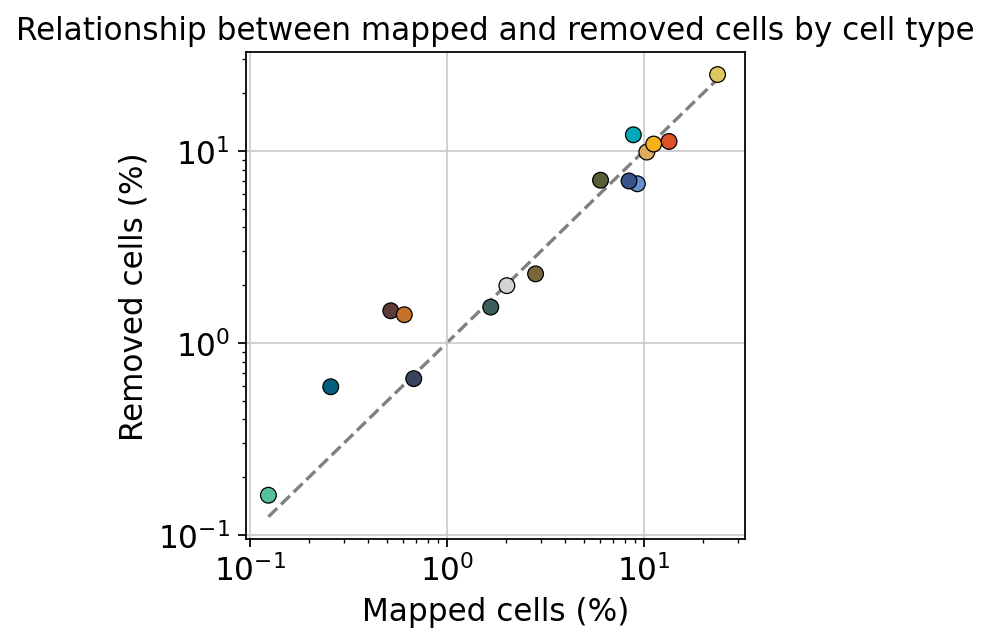

In [164]:
# plot relationship between mapped and removed cells
cell_type_colors = {
    'Naive cytotoxic T cells': '#F6B319',
    'Classical monocytes': '#00A9B8',
    'Cytotoxic memory T cells': '#DEAE5E',
    'Memory Th cells': '#DD5126',
    'CD56dim NK cells': '#3A528A',
    'B cells': '#6492CC',
    'Naive Th cells': '#DEC75E',
    'KLRG1+ cytotoxic memory T cells': '#5E3B39',
    'gd T cells': '#C67129',
    'Unknown': 'lightgrey',
    'Non-classical monocytes': '#056080',
    'CD56high NK cells': '#39445E',
    'KLRG1+ Th cells': '#575E38',
    'Regulatory T cells': '#79663B',
    'Dendritic cells': '#395E5C',
    'Plasmacytoid dendritic cells': '#56C09F'
}

g = sns.scatterplot(x = cell_type_rel_freq['mapped'], y = cell_type_rel_freq['removed'], hue =  cell_type_rel_freq.index, palette = cell_type_colors, s = 50, edgecolor = 'black', zorder = 2)
plt.xlabel('Mapped cells (%)')
plt.ylabel('Removed cells (%)')
plt.title('Relationship between mapped and removed cells by cell type')

# Add a diagonal line
min_val = min(cell_type_rel_freq['mapped'].min(), cell_type_rel_freq['removed'].min())
max_val = max(cell_type_rel_freq['mapped'].max(), cell_type_rel_freq['removed'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray', zorder = 1)

plt.xscale('log')
plt.yscale('log')

plt.legend([], [], frameon=False)
plt.savefig(f'{figure_dir}scatterplot_mario_mapped_vs_removed.pdf')
plt.show()